In [1]:
import os
os.environ['CONFIG'] = 'wrds'
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorly as tl
import warnings
tl.set_backend('numpy')
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from tfm.models.pca import RPPCA, RPPCA_one_window
from tfm.models.tensor import Tensor_One_Window
from tfm.tl_parafac_fix_intercept import parafac_fix_intercept
from tfm.utils import *
from tfm.eval import *

ImportError: cannot import name 'RPPCA_one_window' from 'tfm.models.pca' (/home/james/projects/tsfc/code/code_11092024/tfm/models/pca.py)

### load data

In [2]:
# Read tensor data
D = jnp.load(f'{dir_input}/mat_ptf_re_lag_{max_lag}.npz')
X = D['mat_ptf_re_rank']

config = os.environ.get('CONFIG')
if config == 'char_anom':
    # Read the dictionary parameters
    params = jnp.load(f'{dir_input}/dict_param_lag_{max_lag}.pkl', allow_pickle=True)

    assert params['max_lag'] == max_lag
    bin_labels, _, _, max_lag, frac_longshort, all_dates, start_date_maxlag = params.values()
    T = len(all_dates)
    start_date = all_dates[0]
    dates_fit = all_dates[all_dates < start_date_oos]
    dates_oos = all_dates[all_dates >= start_date_oos]
    T_fit = len(dates_fit)
    T_oos = len(dates_oos)

    # Read FF market factor
    df_ff = jnp.load(f'{dir_input}/df_FF_factors.pkl', allow_pickle=True) * 0.01 
    df_ff = df_ff.loc[all_dates]

    # Get excess returns ie. excess to normal factor
    if input_type == 'rx':
        X = X - X[:, 0, :][:, jnp.newaxis, :]
    if normalize_ret:
        X = X / X.std(axis=0, keepdims=True) * df_ff['Mkt-RF'].std()
elif config == 'wrds' or config == 'scs':
    num_ptf = X.shape[2]
    bin_labels = [str(s) for s in np.arange(X.shape[2])]
    # X_log = jnp.log(1 + X)
    T_oos = 248
    T_fit = X.shape[0] - T_oos
else:
    warnings.warn('Provded dataset should be one of char_anom, scs, or wrds.')

assert not jnp.isnan(X).any()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
print(f'Shape of X: {X.shape}, (Months, Lag, Factor)')
X_fit, X_oos = X[:T_fit], X[T_fit:]
print(f'T_fit: {T_fit}; T_oos: {T_oos}')

# Output directory
dir_out = f'../results_oos/{os.environ['CONFIG']}/fig_onefit_oos_{input_type}_{spec}_ver{idx_ver}/'
dir_out_table = f'../results_oos/{os.environ['CONFIG']}/tbl_onefit_oos_{input_type}_{spec}_ver{idx_ver}/'

if not os.path.exists(dir_out):
    os.makedirs(dir_out)
if not os.path.exists(dir_out_table):
    os.makedirs(dir_out_table)

Shape of X: (493, 60, 107), (Months, Lag, Factor)
T_fit: 245; T_oos: 248


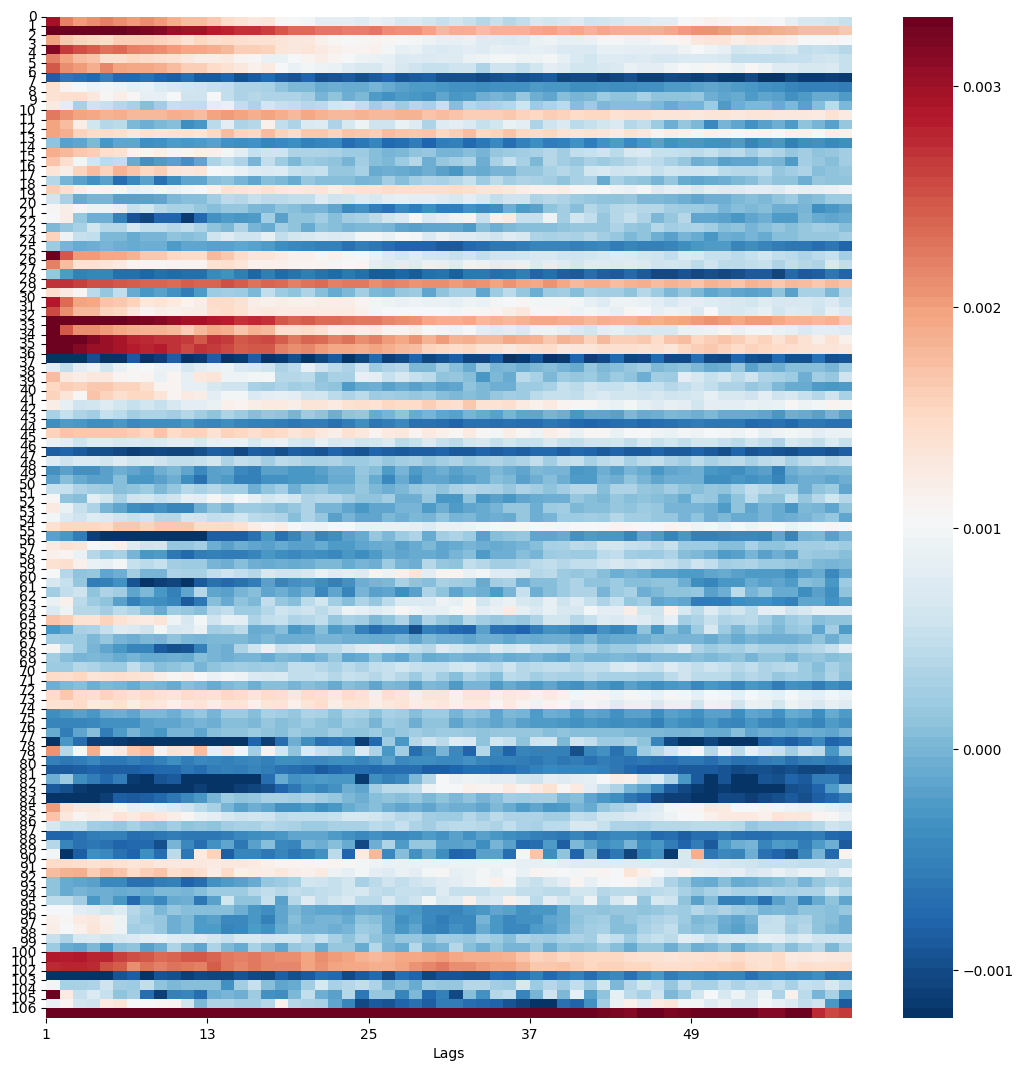

In [5]:
### plot mean return and fitted mean return
X_mean = X[T_fit:].mean(axis=0)
q_ylim = 0.01
ylim_mean = [np.quantile(X_mean, q_ylim), np.quantile(X_mean, 1 - q_ylim)]
# mean oos return
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(1,1,1)    
sns.heatmap(
    X_mean.T, annot=False, fmt='.0e', ax=ax, cmap=sns.color_palette("RdBu_r", n_colors=100),
    vmin=ylim_mean[0], vmax=ylim_mean[1]
);
ax.set_yticks(np.arange(len(bin_labels)))
ax.set_yticklabels(bin_labels, rotation=0);
ax.set_xticks(np.arange(0, max_lag, 12))
ax.set_xticklabels([str(i) for i in np.arange(1,max_lag+1,12)],rotation=0)
ax.set_xlabel('Lags');
filename='term_structure_mean_ret.pdf'
fig.savefig(dir_out+filename, bbox_inches='tight')

In [6]:
# OOS settings
lst_K = [1, 3, 5, 10, 20, 30, 40]

In [7]:
##############
## PCA
##############
dict_fit_oos = defaultdict(dict)

X_flatten = X[:, :max_lag, :].reshape(X.shape[0], -1)
X_onelag_pca = X[:, 1, :] if fit_rx else X[:, 0, :] # False in this nb

dict_fit_pca_onelag = RPPCA_one_window(
    X_onelag_pca[:T_fit], X_onelag_pca[T_fit:], lst_K, gamma=-1
)

dict_fit_pca = RPPCA_one_window(
    X_flatten[:T_fit], X_flatten[T_fit:], lst_K, gamma=-1
)

for idx_K, K in enumerate(lst_K):
    dict_fit_oos['PCA'][K] = {
        'ret_mv_oos': dict_fit_pca['mat_ret_mv_oos'][:, idx_K],
        'X_fitted_oos': dict_fit_pca['mat_X_fitted_oos'][:, idx_K, :].reshape(T_oos, max_lag, num_ptf),
        'sr_oos': dict_fit_pca['sr_oos'][idx_K]
    }
    
    dict_fit_oos['PCA One Lag'][K] = {
        'ret_mv_oos': dict_fit_pca_onelag['mat_ret_mv_oos'][:, idx_K],
        'X_fitted_oos': dict_fit_pca_onelag['mat_X_fitted_oos'][:, idx_K, :],
        'sr_oos':dict_fit_pca_onelag['sr_oos'][idx_K]
    }

100%|██████████| 7/7 [00:19<00:00,  2.77s/it]


### tensor

In [8]:
dict_fit_oos['Tensor'] = Tensor_One_Window(np.asarray(X[:T_fit]), np.asarray(X[T_fit:]), lst_K)

  0%|          | 0/7 [00:00<?, ?it/s]

Tensor: Processing K=1 ...


 14%|█▍        | 1/7 [00:00<00:02,  2.76it/s]

Tensor: Processing K=3 ...


 29%|██▊       | 2/7 [00:03<00:09,  1.91s/it]

Tensor: Processing K=5 ...


 43%|████▎     | 3/7 [00:08<00:12,  3.25s/it]

Tensor: Processing K=10 ...


 57%|█████▋    | 4/7 [00:17<00:16,  5.62s/it]

Tensor: Processing K=20 ...


 71%|███████▏  | 5/7 [00:36<00:20, 10.39s/it]

Tensor: Processing K=30 ...


 86%|████████▌ | 6/7 [01:04<00:16, 16.29s/it]

Tensor: Processing K=40 ...


100%|██████████| 7/7 [01:42<00:00, 14.63s/it]


In [9]:
# mean fitted oos return
for method in ['Tensor', 'PCA']:
    for idx_K, K in enumerate(lst_K):
        # get fitted expected return
        X_fit_oos=dict_fit_oos[method][K]['X_fitted_oos']
        expected_re_fit=X_fit_oos.mean(axis=0)

        # plot
        fig=plt.figure(figsize=(13,13))
        ax=fig.add_subplot(1,1,1)    
        sns.heatmap(expected_re_fit.T,
                    annot=False,
                    fmt='.0e',
                    ax=ax,
                    cmap=sns.color_palette("RdBu_r", n_colors=100),
                    vmin=ylim_mean[0], vmax=ylim_mean[1]
        );
        ax.set_yticks(np.arange(len(bin_labels)))
        ax.set_yticklabels(bin_labels, rotation=0);
        ax.set_xticks(np.arange(0,max_lag,12))
        ax.set_xticklabels([str(i) for i in np.arange(1,max_lag+1,12)],rotation=0)
        ax.set_xlabel('Lags');

        filename='term_structure_{}_fitted_ret_K{}.pdf'\
            .format(method, K)
        #print(filename)
        fig.savefig(dir_out+filename, bbox_inches='tight')
        plt.close('all')



In [10]:
for method in ['Tensor', 'PCA']: 
    for idx_K, K in enumerate(lst_K):

        X_rc=dict_fit_oos[method][K]['X_fitted_oos']

        dict_eval_temp=calc_eval_metrics(X[T_fit:], X_rc)
        dict_fit_oos[method][K]['eval']=dict_eval_temp

In [11]:
### alpha
print_multiplier=1

for method in ['Tensor','PCA']:
    for K in lst_K:
        dict_eval=dict_fit_oos[method][K]['eval']
        latex=print_matrix(dict_eval['alpha'], fmt='{:.2e}', 
                        col_title=[str(s) for s in bin_labels],
                        row_title=['Lag {}'.format(i+1) for i in range(max_lag)],
                         print_multiplier=print_multiplier)
        
        text_file = open(dir_out_table+'tbl_{}_alpha_K_{}.txt'.format(method, K), 'w')
        text_file.write('Multiplier: {:.2e}; Method: {}; K: {}\n\n'.format(print_multiplier, method, K))
        text_file.write(latex)
        text_file.close()

In [12]:
### table for xs-alpha, averaged over lag or ptf dim

print_multiplier=1e3

for method in ['Tensor', 'PCA']:
    for postfix in ['','_1ex']:
        dict_eval=dict_fit_oos[method]
        
        latex_ptf=print_matrix(collect_eval_metric(dict_eval, lst_K, 'xs_alpha_ptf'+postfix),
                     row_title=[str(s) for s in bin_labels],
                     col_title=[str(K) for K in lst_K],
                     print_multiplier=print_multiplier,
                     fmt='{:.2f}')


        latex_lag=print_matrix(collect_eval_metric(dict_eval, lst_K, 'xs_alpha_lag'+postfix),
                     row_title=[str(L) for L in range(1,1+max_lag)],
                     col_title=[str(K) for K in lst_K],
                     print_multiplier=print_multiplier,
                     fmt='{:.2f}')

        # save rms alpha as table in txt for latex
        text_file = open(dir_out_table+'tbl_{}_xs_alpha_ptf{}.txt'.format(method, postfix), 'w')
        text_file.write('Multiplier: {:.2e}; Method: {}; \n\n'.format(print_multiplier, method))
        text_file.write(latex_ptf)
        text_file.close()

        text_file = open(dir_out_table+'tbl_{}_xs_alpha_lag{}.txt'.format(method, postfix), 'w')
        text_file.write('Multiplier: {:.2e}; Method: {}; \n\n'.format(print_multiplier, method))
        text_file.write(latex_lag)
        text_file.close()

In [13]:
### sigma_eps unexplained variance
print_multiplier = 1

for postfix in ['','_1ex']:
    

    metric_tensor = collect_eval_metric(dict_fit_oos['Tensor'],
                                        lst_K, 'sigma_eps'+postfix)
    metric_pca = collect_eval_metric(dict_fit_oos['Tensor'],
                                     lst_K, 'sigma_eps'+postfix)
    metric_pca = np.real(metric_pca)
    metric = np.stack((metric_tensor,metric_pca), axis=-1)

    latex = print_matrix(metric,
                 col_title=['Tensor', 'PCA'],
                 row_title=[str(K) for K in lst_K],
                 print_multiplier=print_multiplier,
                 fmt='{:.2f}')

    text_file = open(dir_out_table+'tbl_{}_sigma_eps{}.txt'.format(method, postfix), 'w')
    text_file.write('Multiplier: {:.2e}\n\n'.format(print_multiplier))
    text_file.write(latex)
    text_file.close()

In [14]:
### table for eps_cross_rms
print_multiplier=1e2

for method in ['Tensor','PCA']:
    latex=print_matrix(collect_eval_metric(dict_fit_oos[method],
                                           lst_K, 'eps_cross_rms'),
                                         fmt='{:.2f}', 
                                        col_title=[str(K) for K in lst_K],
                                         row_title=[str(s) for s in bin_labels],
                                         print_multiplier=print_multiplier)
    
    text_file = open(dir_out_table+'tbl_{}_rms_eps_cross.txt'.format(method), 'w')
    text_file.write('Multiplier: {:.2e}; Method: {} \n\n'.format(print_multiplier, method))
    text_file.write(latex)
    text_file.close()

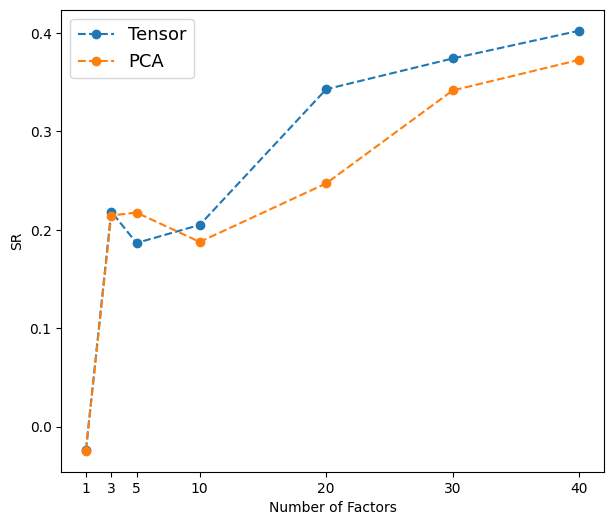

In [15]:
#ylim=[-0.1, 1.9]
filename = 'sr.pdf'

dict_fit_oos['Tensor'][1]['sr_oos'] = dict_fit_oos['Tensor'][1]['sr_oos'][0]

fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)

for method in ['Tensor','PCA']:
    ax.plot(lst_K, np.array([dict_fit_oos[method][K]['sr_oos'] for K in lst_K]),
            '--o',label=method)
ax.legend(fontsize=13);
ax.set_ylabel('SR')
ax.set_xlabel('Number of Factors')
ax.set_xticks(lst_K);
#ax.set_ylim(ylim)

fig.savefig(dir_out, bbox_inches='tight')

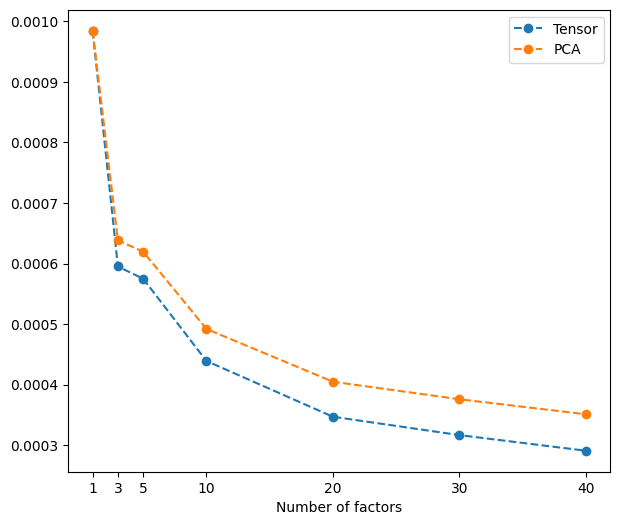

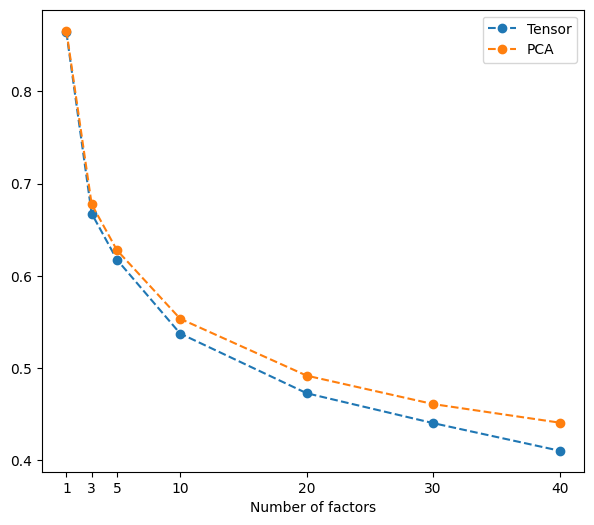

In [16]:
### xs-alpha and sigma_eps

for key in ['xs_alpha','sigma_eps']:

    fig=plt.figure(figsize=(7,6))
    ax=fig.add_subplot(1,1,1)
    for method in ['Tensor','PCA']:
        metric=np.real(collect_eval_metric(dict_fit_oos[method], lst_K, key))
        ax.plot(lst_K, metric,'--o',
                label=method)
    ax.set_xlabel('Number of factors');
    ax.legend();
    ax.set_xticks(lst_K);
    fig.savefig(dir_out+'{}.pdf'.format(key), bbox_inches='tight')

In [17]:
### plot term structure of alpha
lst_key = ['alpha','var_resid', 'eps_lag_rms']
filename = 'term_structure_{}_{}_K{}.pdf'
method='Tensor'


for method in ['Tensor', 'PCA']: 
    for key in lst_key:
        ylim = get_plot_ylim(dict_fit_oos[method], lst_K, key, q_lb=0.1)

        for K in lst_K:
            fig=plt.figure(figsize=(13,13))
            ax=fig.add_subplot(1,1,1)    
            sns.heatmap(dict_fit_oos[method][K]['eval'][key].T,
                        annot=False,
                        fmt='.0e',
                        ax=ax,
                        cmap=sns.color_palette("RdBu_r", n_colors=100),
                       vmin=ylim[0], vmax=ylim[1]);

            ax.set_yticks(np.arange(len(bin_labels)))
            ax.set_yticklabels(bin_labels ,rotation=0);

            ax.set_xticks(np.arange(0,max_lag,12))
            ax.set_xticklabels([str(i) for i in np.arange(1,max_lag+1,12)],rotation=0)
            ax.set_xlabel('Lags');

            fig.savefig(dir_out+filename.format(method, key, K), bbox_inches='tight')
            plt.close('all')

